# Capstone 3 Pre-processing and Training Data Development

**The Data Science Method**  

1.   Problem Identification 

2.   Data Wrangling 
  * Data Collection 
   * Data Organization
  * Data Definition 
  * Data Cleaning
 
3.   Exploratory Data Analysis
 * Build data profile tables and plots
        - Outliers & Anomalies
 * Explore data relationships
 * Identification and creation of features

4.   **Pre-processing and Training Data Development**
  * Create dummy or indicator features for categorical variables
  * Standardize the magnitude of numeric features
  * Split into testing and training datasets
  * Apply scaler to the testing set
  
5.   Modeling 
  * Fit Models with Training Data Set
  * Review Model Outcomes — Iterate over additional models as needed.
  * Identify the Final Model

6.   Documentation
  * Review the Results
  * Present and share your findings - storytelling
  * Finalize Code 
  * Finalize Documentation

## Data Collection

In [53]:
#load python packages
import os
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.4f' % x) #get rid of scientific notations
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
from sklearn import preprocessing
import math
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from IPython.display import Image
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss
%matplotlib inline

In [54]:
# switch to processed data folder
os.chdir('C:\\Users\\tc18f\\Desktop\\springboard\\Capstone Three\\data\\processed\\')
os.getcwd()

'C:\\Users\\tc18f\\Desktop\\springboard\\Capstone Three\\data\\processed'

In [55]:
# load the combined csv file
df = pd.read_csv('combined.csv')
df.head()

,Zipcode,County,Date,Value,Bedrooms
0,94109,San Francisco County,1996-01-31,263374,1
1,90250,Los Angeles County,1996-01-31,184141,1
2,90046,Los Angeles County,1996-01-31,119677,1
3,94501,Alameda County,1996-01-31,119742,1
4,94110,San Francisco County,1996-01-31,221428,1


In [56]:
# use info() to check number of rows and data type
df['Date'] = pd.to_datetime(df.Date)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 563732 entries, 0 to 563731
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   Zipcode   563732 non-null  int64         
 1   County    563732 non-null  object        
 2   Date      563732 non-null  datetime64[ns]
 3   Value     563732 non-null  int64         
 4   Bedrooms  563732 non-null  int64         
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 21.5+ MB


In [57]:
Image('C:\\Users\\tc18f\\Desktop\\springboard\\Capstone Three\\figures\\Year x Values by BR.png')

FileNotFoundError: No such file or directory: 'C:\Users\tc18f\Desktop\springboard\Capstone Three\figures\Year x Values by BR.png'

FileNotFoundError: No such file or directory: 'C:\Users\tc18f\Desktop\springboard\Capstone Three\figures\Year x Values by BR.png'

<IPython.core.display.Image object>

From EDA we found out that there's very high correlation between the price houses based on number of bedrooms; we can say that all the houses' prices increases or decreases. So our primary focus should be Zipcode, Value, and Date (we can make 4 different models using 4 data sets with different number of bedrooms, this way we won't have a memory problem).

In [58]:
# break the df into 4 of them indicating the number of bedrooms and drop the county and bedrooms column
df1 = df.loc[df['Bedrooms']==1]
df2 = df.loc[df['Bedrooms']==2]
df3 = df.loc[df['Bedrooms']==3]
df4 = df.loc[df['Bedrooms']==4]
df1.head()

,Zipcode,County,Date,Value,Bedrooms
0,94109,San Francisco County,1996-01-31,263374,1
1,90250,Los Angeles County,1996-01-31,184141,1
2,90046,Los Angeles County,1996-01-31,119677,1
3,94501,Alameda County,1996-01-31,119742,1
4,94110,San Francisco County,1996-01-31,221428,1


# Stationary Test

In [60]:
# add logged value
df1['logged_value'] = np.log(df1.Value)
# add rooted value as well
df1['rooted_value'] = np.sqrt(df1.Value)
df1['CR_value'] = df1['Value'].apply(lambda x: (x**(1/3)))
df1['logged_value10'] = df1['Value'].apply(lambda x: math.log(x, 10))
df1.head()

,Zipcode,County,Date,Value,Bedrooms,logged_value,rooted_value,CR_value,logged_value10
0,94109,San Francisco County,1996-01-31,263374,1,12.4813,513.1998,64.0999,5.4206
1,90250,Los Angeles County,1996-01-31,184141,1,12.1235,429.1165,56.8919,5.2652
2,90046,Los Angeles County,1996-01-31,119677,1,11.6926,345.9436,49.2799,5.0780
3,94501,Alameda County,1996-01-31,119742,1,11.6931,346.0376,49.2889,5.0782
4,94110,San Francisco County,1996-01-31,221428,1,12.3079,470.5614,60.4984,5.3452


In [51]:
# define a function that takes in the df, and its col_name and do the stationary tests and return the results
def stationary_test(df, col_name, diff_value):
    warnings.filterwarnings("ignore")
    # get the zipcode to iterate
    unique_zip = list(df.Zipcode.unique())
    # create an empty list to store p-values for each zipcode
    p_valuesA = []
    p_valuesK = []    
    # iterate and append p-values
    for zipcode in unique_zip:
        df_sub = df[df['Zipcode']==zipcode][col_name]
        if diff_value:
            df_sub = df_sub.diff(diff_value).dropna()
        adf_p = adfuller(df_sub, autolag='AIC')[1]
        p_valuesA.append(adf_p)
        kpss_p = kpss(df_sub)[1]
        p_valuesK.append(kpss_p)
    # create empty lists
    ADF_S_list=[]
    ADF_NS_list=[]
    # iterate thrue p_valuesA to add to stationary/non-stationary list
    for p in p_valuesA:
        if p < 0.05:
            ADF_S_list.append(p)
        else:
            ADF_NS_list.append(p)
    # create emty lists
    kpss_S_list=[]
    kpss_NS_list=[]
    # iterate thrue p_valuesK to add to stationary/non-stationary list
    for p in p_valuesK:
        if p > 0.05:
            kpss_S_list.append(p)
        else:
            kpss_NS_list.append(p)
    print('ADF-Stationary:',len(ADF_S_list))
    print('ADF-Non-Stationary:', len(ADF_NS_list))
    print('kpss-Stationary:',len(kpss_S_list))
    print('kpss-Non-Stationary:', len(kpss_NS_list))
    return

# Stationary test on Value, logged value, rooted value

In [57]:
stationary_test(df1, 'Value', 0)

ADF-Stationary: 41
ADF-Non-Stationary: 440
kpss-Stationary: 9
kpss-Non-Stationary: 472


In [51]:
stationary_test(df1, 'logged_value', 0)

ADF-Stationary: 71
ADF-Non-Stationary: 410
kpss-Stationary: 4
kpss-Non-Stationary: 477


In [52]:
stationary_test(df1, 'rooted_value', 0)

ADF-Stationary: 44
ADF-Non-Stationary: 437
kpss-Stationary: 6
kpss-Non-Stationary: 475


In [8]:
stationary_test(df1, 'CR_value', 0)

ADF-Stationary: 51
ADF-Non-Stationary: 430
kpss-Stationary: 6
kpss-Non-Stationary: 475


In [61]:
stationary_test(df1, 'logged_value10', 0)

ADF-Stationary: 71
ADF-Non-Stationary: 410
kpss-Stationary: 4
kpss-Non-Stationary: 477


# Stationary test on scaled data

In [9]:
df1.head()

,Zipcode,County,Date,Value,Bedrooms,logged_value,rooted_value
0,94109,San Francisco County,1996-01-31,263374,1,12.481330,513.199766
1,90250,Los Angeles County,1996-01-31,184141,1,12.123457,429.116534
2,90046,Los Angeles County,1996-01-31,119677,1,11.692552,345.943637
3,94501,Alameda County,1996-01-31,119742,1,11.693095,346.037570
4,94110,San Francisco County,1996-01-31,221428,1,12.307853,470.561367


In [15]:
# need to make a function that takes in df1 and returns it with scaled Value
def df_scaler(df):
    temp = pd.DataFrame({'Date':pd.date_range('1996-01-31', periods=293, freq='M')}) # create a df to store values
    for zipcode in list(df.Zipcode.unique()):
        df_sub = df[df['Zipcode']==zipcode] 
        df_X = df_sub[['Value']]
        scaler = preprocessing.StandardScaler().fit(df_X)
        df_X_scaled = scaler.transform(df_X)
        temp[zipcode] = list(df_X_scaled)
    # melt and sort
    temp_melt = pd.melt(temp, id_vars=['Date'], var_name='Zipcode', value_name='scaled_val')
    temp_sort = temp_melt.sort_values(['Date','Zipcode'])
    temp_sort['scaled_val'] = temp_sort['scaled_val'].astype('float64')
    return temp_sort

In [16]:
df1_scaled = df_scaler(df1)
df1_scaled

,Date,Zipcode,scaled_val
6446,1996-01-31,90004,-1.558435
58893,1996-01-31,90007,-1.324218
59479,1996-01-31,90012,-1.595727
32523,1996-01-31,90016,-1.274738
33109,1996-01-31,90018,-1.287112
...,...,...,...
44828,2020-05-31,95821,1.759878
34280,2020-05-31,95822,2.830744
43070,2020-05-31,95825,2.211099
104600,2020-05-31,96150,1.366019


In [17]:
stationary_test(df1_scaled, 'scaled_val', 0)

ADF-Stationary: 41
ADF-Non-Stationary: 440
kpss-Stationary: 9
kpss-Non-Stationary: 472


Standardized or not has the same result.

# Stationary test on differenced data

In [53]:
stationary_test(df1, 'Value', 1)

ADF-Stationary: 22
ADF-Non-Stationary: 459
kpss-Stationary: 464
kpss-Non-Stationary: 17


In [54]:
stationary_test(df1, 'logged_value', 1)

ADF-Stationary: 29
ADF-Non-Stationary: 452
kpss-Stationary: 480
kpss-Non-Stationary: 1


In [55]:
stationary_test(df1, 'rooted_value', 1)

ADF-Stationary: 27
ADF-Non-Stationary: 454
kpss-Stationary: 476
kpss-Non-Stationary: 5


In [9]:
stationary_test(df1, 'CR_value', 1)

ADF-Stationary: 28
ADF-Non-Stationary: 453
kpss-Stationary: 480
kpss-Non-Stationary: 1


In [62]:
stationary_test(df1, 'logged_value10', 1)

ADF-Stationary: 29
ADF-Non-Stationary: 452
kpss-Stationary: 480
kpss-Non-Stationary: 1


In [18]:
stationary_test(df1_scaled, 'scaled_val', 1)

ADF-Stationary: 22
ADF-Non-Stationary: 459
kpss-Stationary: 464
kpss-Non-Stationary: 17


Seems like the data set is kpss stationary after one differencing.

In [12]:
# define a function that takes in the df, and its col_name and return a df with diff() with column val as zipcode
def diff_func(df, col_name):
    warnings.filterwarnings("ignore")
    # get the zipcode to iterate
    unique_zip = list(df.Zipcode.unique())
    # create an empty list to store p-values for each zipcode
    # iterate and append p-values
    temp = pd.DataFrame({'Date':pd.date_range('1996-02-29', periods=292, freq='M')})
    for zipcode in unique_zip:
        df_sub = df[df['Zipcode']==zipcode][col_name]
        df_sub = df_sub.diff().dropna()
        temp[zipcode] = list(df_sub)
    return temp

In [14]:
df1_diff = diff_func(df1, 'Value')
df1_dm = pd.melt(df1_diff, 'Date')
df1_dm

,Date,variable,value
0,1996-02-29,94109,-801.0
1,1996-03-31,94109,281.0
2,1996-04-30,94109,548.0
3,1996-05-31,94109,1577.0
4,1996-06-30,94109,1266.0
...,...,...,...
140447,2020-01-31,92341,93.0
140448,2020-02-29,92341,354.0
140449,2020-03-31,92341,450.0
140450,2020-04-30,92341,198.0


In [ ]:
sns.lineplot

# Stationary test on diff(12) since it's monthly data

In [56]:
stationary_test(df1, 'Value', 12)

ADF-Stationary: 242
ADF-Non-Stationary: 239
kpss-Stationary: 463
kpss-Non-Stationary: 18


In [58]:
stationary_test(df1, 'logged_value', 12)

ADF-Stationary: 140
ADF-Non-Stationary: 341
kpss-Stationary: 479
kpss-Non-Stationary: 2


In [59]:
stationary_test(df1, 'rooted_value', 12)

ADF-Stationary: 204
ADF-Non-Stationary: 277
kpss-Stationary: 478
kpss-Non-Stationary: 3


In [19]:
stationary_test(df1_scaled, 'scaled_val', 12)

ADF-Stationary: 242
ADF-Non-Stationary: 239
kpss-Stationary: 463
kpss-Non-Stationary: 18


Even tough diff(12) helped, most of the ADF tests were still not stationary. Let's try differencing first, then cuberoot (due to negative number).

# Diff() then root

In [18]:
# define a function that takes in the df, and the number of diff value and root value (needs to be odd numbers)
def stationary_test_R(df, diff_val, root_val):
    warnings.filterwarnings("ignore") #ignore warnings
    # get the zipcode to iterate
    unique_zip = list(df.Zipcode.unique())
    # create an empty list to store p-values for each zipcode
    p_valuesA = []
    p_valuesK = []    
    # iterate and append p-values
    for zipcode in unique_zip:
        df_sub = df[df['Zipcode']==zipcode]
        df_diff = df_sub[['Value']].diff(diff_val).dropna()
        df_diff['root'] = df_diff['Value'].apply(lambda x: (x**(root_val)))
        df_diff['root'] = df_diff['root'].apply(lambda x: x.real)
        adf_p = adfuller(df_diff['root'], autolag='AIC')[1]
        p_valuesA.append(adf_p)
        kpss_p = kpss(df_diff['root'])[1]
        p_valuesK.append(kpss_p)
    # create empty lists
    ADF_S_list=[]
    ADF_NS_list=[]
    # iterate thrue p_valuesA to add to stationary/non-stationary list
    for p in p_valuesA:
        if p < 0.05:
            ADF_S_list.append(p)
        else:
            ADF_NS_list.append(p)
    # create emty lists
    kpss_S_list=[]
    kpss_NS_list=[]
    # iterate thrue p_valuesK to add to stationary/non-stationary list
    for p in p_valuesK:
        if p > 0.05:
            kpss_S_list.append(p)
        else:
            kpss_NS_list.append(p)
    print('ADF-Stationary:',len(ADF_S_list))
    print('ADF-Non-Stationary:', len(ADF_NS_list))
    print('kpss-Stationary:',len(kpss_S_list))
    print('kpss-Non-Stationary:', len(kpss_NS_list))
    return

In [19]:
# try difference once and cube root
stationary_test_R(df1, 1, 1/3)

ADF-Stationary: 330
ADF-Non-Stationary: 151
kpss-Stationary: 437
kpss-Non-Stationary: 44


About 1/3 of data won't be able to be used, let's try 5th root.

In [20]:
# try difference once and 1/5 root
stationary_test_R(df1, 1, 1/5)

ADF-Stationary: 420
ADF-Non-Stationary: 61
kpss-Stationary: 392
kpss-Non-Stationary: 89


Much better, but there are still some dataset arne't stationary, we will select zipcodes that were stationary.

In [25]:
# define a function that takes in the df, and the number of diff value and root value (needs to be odd numbers)
def stationary_zip(df, diff_val, root_val):
    warnings.filterwarnings("ignore") #ignore warnings
    # get the zipcode to iterate
    unique_zip = list(df.Zipcode.unique())
    # create an empty list to store p-values for each zipcode
    adf_zipcode = []
    kpss_zipcode = []    
    # iterate and append p-values
    for zipcode in unique_zip:
        df_sub = df[df['Zipcode']==zipcode]
        df_diff = df_sub[['Value']].diff(diff_val).dropna()
        df_diff['root'] = df_diff['Value'].apply(lambda x: (x**(root_val)))
        df_diff['root'] = df_diff['root'].apply(lambda x: x.real)
        adf_p = adfuller(df_diff['root'], autolag='AIC')[1]
        if adf_p < 0.05:
            adf_zipcode.append(zipcode)
        kpss_p = kpss(df_diff['root'])[1]
        if kpss_p > 0.05:
            kpss_zipcode.append(zipcode)
        inner_joined_zip = list(set(adf_zipcode) & set(kpss_zipcode))
    return inner_joined_zip

In [34]:
stationary_zip1 = stationary_zip(df1, 1, 1/5)
stationary_zip2 = stationary_zip(df2, 1, 1/5)
stationary_zip3 = stationary_zip(df3, 1, 1/5)
stationary_zip4 = stationary_zip(df4, 1, 1/5)

In [35]:
stationary_zipcodes5 = list(set(stationary_zip1) & set(stationary_zip2) & set(stationary_zip3) & set(stationary_zip4))
len(stationary_zipcodes5)

239

We lost more than half the data, let's try cube root.

In [29]:
stationary_zip1 = stationary_zip(df1, 1, 1/3)
stationary_zip2 = stationary_zip(df2, 1, 1/3)
stationary_zip3 = stationary_zip(df3, 1, 1/3)
stationary_zip4 = stationary_zip(df4, 1, 1/3)

In [31]:
stationary_zipcodes3 = list(set(stationary_zip1) & set(stationary_zip2) & set(stationary_zip3) & set(stationary_zip4))
len(stationary_zipcodes3)

147

Let's try 1/7 root

In [32]:
stationary_zip1 = stationary_zip(df1, 1, 1/7)
stationary_zip2 = stationary_zip(df2, 1, 1/7)
stationary_zip3 = stationary_zip(df3, 1, 1/7)
stationary_zip4 = stationary_zip(df4, 1, 1/7)

In [33]:
stationary_zipcodes7 = list(set(stationary_zip1) & set(stationary_zip2) & set(stationary_zip3) & set(stationary_zip4))
len(stationary_zipcodes7)

235

Looks like 1/5 root has the most stationary zipcodes, let's use these zipcode and subset df then save the csv.

In [40]:
df_stationary = df[df['Zipcode'].isin(stationary_zipcodes5)]
len(df_stationary)

280108

In [43]:
df_stationary.to_csv('stationary_zipcode_data.csv', index=False)

# Split and Train

In [24]:
# find the total number of months
df1.Date.nunique()

293

In [25]:
# find the starting and end date
display(df1.iloc[0])
display(df1.iloc[-1])

Zipcode                        94109
County          San Francisco County
Date             1996-01-31 00:00:00
Value                         263374
Bedrooms                           1
logged_value                 12.4813
rooted_value                   513.2
Name: 0, dtype: object

Zipcode                         92341
County          San Bernardino County
Date              2020-05-31 00:00:00
Value                          162622
Bedrooms                            1
logged_value                  11.9992
rooted_value                  403.264
Name: 140932, dtype: object

In [26]:
# find the number of zipcodes, we will need to change the date to integer in order to use linear regression model
df1.Zipcode.nunique()

481

In [27]:
# set the training and testing data sets (need to change the date to integers)
# create a new date called date_int, starting 1 as 1996 Jan, and ending on 293 as 2020-May
date_int=[]
for i in range(1, 294):
    for j in range(481):
        date_int.append(i)
date_int[-1]

293

In [28]:
# add the new date to df1
df1['date_ranked']=date_int
df1.head()

,Zipcode,County,Date,Value,Bedrooms,logged_value,rooted_value,date_ranked
0,94109,San Francisco County,1996-01-31,263374,1,12.481330,513.199766,1
1,90250,Los Angeles County,1996-01-31,184141,1,12.123457,429.116534,1
2,90046,Los Angeles County,1996-01-31,119677,1,11.692552,345.943637,1
3,94501,Alameda County,1996-01-31,119742,1,11.693095,346.037570,1
4,94110,San Francisco County,1996-01-31,221428,1,12.307853,470.561367,1


In [29]:
# check for Dtypes
df1.info() # need to remember to change Zipcode to int in order to use linear regression model

<class 'pandas.core.frame.DataFrame'>
Int64Index: 140933 entries, 0 to 140932
Data columns (total 8 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Zipcode       140933 non-null  int64         
 1   County        140933 non-null  object        
 2   Date          140933 non-null  datetime64[ns]
 3   Value         140933 non-null  int64         
 4   Bedrooms      140933 non-null  int64         
 5   logged_value  140933 non-null  float64       
 6   rooted_value  140933 non-null  float64       
 7   date_ranked   140933 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(4), object(1)
memory usage: 9.7+ MB


In [30]:
# get the X, y ready for split_train
X=[]
y=[]
for i in range(len(df1)):
    X.append([int(df1.Zipcode.iloc[i]), df1.date_ranked.iloc[i]])
    y.append([df1.Value.iloc[i]])

In [31]:
# train_test_split
X_train, X_test, y_train, y_test = train_test_split(np.array(X), y, test_size=0.1, random_state=42)

In [32]:
# check and see if train_test_split worked
X_train

array([[93101,   126],
       [90212,   169],
       [94121,   111],
       ...,
       [94134,   216],
       [92054,   275],
       [93420,   254]], dtype=int64)

# Baseline
We will use the Linear Regression Model as baseline model to see if the values of the houses will increase or decrease in the future 36 months

In [33]:
# use linear regression model as baseline model
linreg = LinearRegression().fit(X_train, y_train)

In [34]:
# let's check the score
linreg.score(X_test,y_test) # rather horrible, 0.2580

0.2580036985682179

In [35]:
# get the list of unique zipcodes as int
zipcodes = df1.Zipcode.unique().astype('int32')

In [36]:
# create a forecast data array to input and see the prediction for the next 24 months which is month_ranked 294-317
X_fc=[]
for i in range(294, 318):
    for j in list(zipcodes):
        X_fc.append([j, i])

In [37]:
# check number of predictions expected
len(X_fc)

11544

In [38]:
# check for last array, which should be last zipcode and 317
X_fc[-1]

[92341, 317]

In [39]:
# get prediction from X
y_pred_array = linreg.predict(X) #the return result is arrays

# make the array into a list
y_pred_list = y_pred_array.astype('int32').tolist()
y_pred=[]
for i in range(len(y_pred_list)):
    y_pred.append(y_pred_list[i][0])
y_pred[0]

169798

In [40]:
# add the prediction to df1
df1['pred']=y_pred

In [41]:
# get forecasts from linreg.predict(X_fc)
y_fc_array = linreg.predict(X_fc)

# make the array into a list
y_fc_list = y_fc_array.astype('int32').tolist()
y_fc=[]
for i in range(len(y_fc_list)):
    y_fc.append(y_fc_list[i][0])
y_fc[0]

523115

In [42]:
# make a dataframe with forecast data
# make zipcode lists
zipcode_list=list(df1.Zipcode.iloc[:(24*481)].astype('int32'))
                        
# make date_ranked list                 
date_ranked_list=[]
for i in range(294, (294+24)): # 24 more months
    for j in range(481): #481 zipcodes each month
        date_ranked_list.append(i)
                        
# make a prediction dict    
fc_dict={
    'Zipcode':zipcode_list,
    'date_ranked':date_ranked_list,
    'forecast':y_fc
}

fc_df = pd.DataFrame(data=fc_dict)
fc_df

,Zipcode,date_ranked,forecast
0,94109,294,523115
1,90250,294,458691
2,90046,294,455286
3,94501,294,529660
4,94110,294,523132
...,...,...,...
11539,95664,317,576810
11540,94586,317,558813
11541,95439,317,573054
11542,95497,317,574022


since we have 481 zipcodes, we will plot the average and medians instead of 481 line plots

In [43]:
# define a function that takes in the df (the very first excel file) and bedroom number to get the median
def z_median_calc(df, BR):
    z_medians = []
    for date in list(df.Date.unique()):
        df_sub = df[(df['Date']==date) & (df['Bedrooms']==BR)] # subset to corresponding month and num of BR
        df_sub = df_sub.sort_values('Value') # sort by Value so we can find the median
        median = df_sub.iloc[240].Value #the 241st, since zero index 240
        z_medians.append(median)
    return z_medians
# do the same to get the z_mean
def z_mean_calc(df, BR):
    z_means = []
    df_sub = df[df['Bedrooms']==BR]
    for i in list(df_sub.Date.unique()): # get the dates to iterate
        mean = df_sub[df_sub['Date']==i].Value.mean() # get the mean
        z_means.append(int(mean))
    return z_means

In [45]:
# create a dataframe and save the z mean/median to csv file
z_avg = pd.DataFrame({
    'Date':pd.date_range('1996-01-31', periods=293, freq='M'),
    'median1': z_median_calc(df, 1),
    'median2': z_median_calc(df, 2),
    'median3': z_median_calc(df, 3),
    'median4': z_median_calc(df, 4),
    'mean1': z_mean_calc(df, 1),
    'mean2': z_mean_calc(df, 2),
    'mean3': z_mean_calc(df, 3),
    'mean4': z_mean_calc(df, 4),
})
z_avg.to_csv('z_avg.csv', index=False)

In [46]:
# get the prediction's medians
p_medians = []
for i in range(1,294): # zillow's ranked date only up to 293
    median = df1.loc[df1['date_ranked']==i].sort_values('pred').iloc[240].pred
    p_medians.append(int(median))

# get the prediction's means
p_means = []
for i in range(1,294): # zillow's ranked date only up to 293
    mean = df1.loc[df1['date_ranked']==i].pred.mean()
    p_means.append(int(mean))

In [47]:
# get the forecast medians
f_medians = []
for i in range(294,318):
    median = fc_df.loc[fc_df['date_ranked']==i].sort_values('forecast').iloc[240].forecast
    f_medians.append(int(median))

# get the forecast means
f_means = []
for i in range(294,318):
    mean = fc_df.loc[fc_df['date_ranked']==i].forecast.mean()
    f_means.append(int(mean))

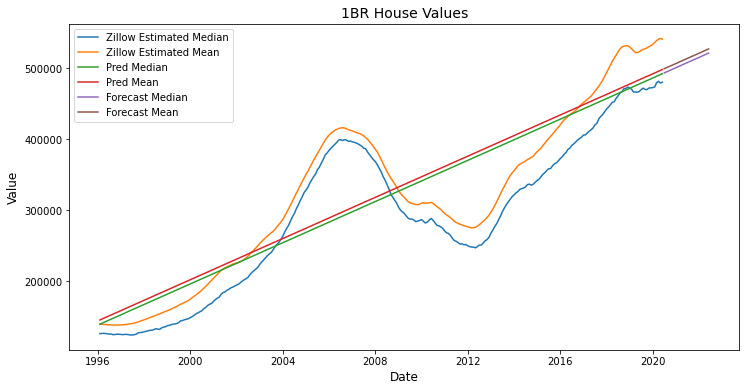

In [64]:
# plot the zillow medians/means vs predictions' medians/means
# define the x and y's
fig = plt.subplots(1,1,figsize=(12,6))
x1 = pd.date_range('1996-01-01', periods=293, freq='M')
z1 = z_avg.median1
z2 = z_avg.mean1
p1 = p_medians
p2 = p_means

x2 = pd.date_range('2020-06-01', periods=24, freq='M')
f1 = f_medians
f2 = f_means

# plot within same figure
fig = plt.plot(x1, z1, label='Zillow Estimated Median')
fig = plt.plot(x1, z2, label='Zillow Estimated Mean')
fig = plt.plot(x1, p1, label='Pred Median')
fig = plt.plot(x1, p2, label='Pred Mean')
fig = plt.plot(x2, f1, label='Forecast Median')
fig = plt.plot(x2, f2, label='Forecast Mean')

plt.xlabel('Date', size=12)
plt.ylabel('Value', size=12)
plt.title('1BR House Values', size=14)
plt.legend()
plt.show()

From the baseline model (linear regression), overall (both mean and median) points to increasing in house values.